# Data Cleaning Using Machine Learning

In [130]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

Mainly 3 things to do :
* Process data to be able to manipulate it (convert "object" to "float)
* Remove missing data
* Detect wrong data

## Loading data

Just for one file.

In [131]:
df = pd.read_csv("data/curva_pbc_uof_20240201.1", delimiter=";", encoding="latin1", header=1)
del df["Unnamed: 8"]
df.head()

,Hora,Fecha,Pais,Unidad,Tipo Oferta,Energía Compra/Venta,Precio Compra/Venta,Ofertada (O)/Casada (C)
0,1.0,01/02/2024,MI,TOTRM01,C,"496,0","1.500,00",O
1,1.0,01/02/2024,MI,TOTRM02,C,"138,0","1.500,00",O
2,1.0,01/02/2024,MI,TOTRM03,C,"56,0","1.500,00",O
3,1.0,01/02/2024,MI,BPRM01,C,"31,4","1.002,00",O
4,1.0,01/02/2024,MI,EUCDR01,C,"9,3","1.002,00",O


In [132]:
df.dtypes

Hora                       float64
Fecha                       object
Pais                        object
Unidad                      object
Tipo Oferta                 object
Energía Compra/Venta        object
Precio Compra/Venta         object
Ofertada (O)/Casada (C)     object
dtype: object

## Removing missing data

In [133]:
df = df.fillna({"Energía Compra/Venta" : "0", "Precio Compra/Venta" : "0"})

## Processing data

### Hora, Pais, Unidad, Tipo Oferta, Ofertada/Casada

Nothing to do

### Fecha

Convert object into datetimes

In [134]:
df.Fecha.iloc[0]

'01/02/2024'

In [135]:
...

Ellipsis

### Energia Compra/Venta, Precio Compra/Venta

Convert from string to float replacing :
* Thousand delimiter "." to nothing
* Decimal delimiter "," to "."

In [136]:
a = "1.500,00"
a = a.replace(".", "")
a = a.replace(",", ".")
a = float(a)
print(a)

1500.0


In [137]:
for e in df["Energía Compra/Venta"]:
    if type(e)!=str:
        print(e)

In [138]:
df["Energía Compra/Venta"] = df["Energía Compra/Venta"].apply(lambda x: float(x.replace(".", "").replace(",", ".")))
df["Precio Compra/Venta"] = df["Precio Compra/Venta"].apply(lambda x: float(x.replace(".", "").replace(",", ".")))
df.dtypes

Hora                       float64
Fecha                       object
Pais                        object
Unidad                      object
Tipo Oferta                 object
Energía Compra/Venta       float64
Precio Compra/Venta        float64
Ofertada (O)/Casada (C)     object
dtype: object

## Detecting wrong data

I will use a method based on machine learning.

The columns that might contain wrong data are :
* Energia Compra/Venta
* Precio Compra/Venta

(array([6.3500e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+01, 0.0000e+00,
        4.8000e+01, 2.1000e+02, 1.9580e+03, 3.0060e+03, 4.8116e+04,
        3.3800e+03, 4.5150e+03, 2.4180e+03, 1.9400e+02, 3.8500e+02,
        9.2000e+01, 2.4000e+01, 5.6300e+02, 0.0000e+00, 2.4000e+01,
        2.5000e+02, 3.3200e+02, 0.0000e+00, 1.9300e+02, 0.0000e+00,
        0.0000e+00, 1.9200e+02, 1.5500e+02, 0.0000e+00, 7.2000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 9.5200e+02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

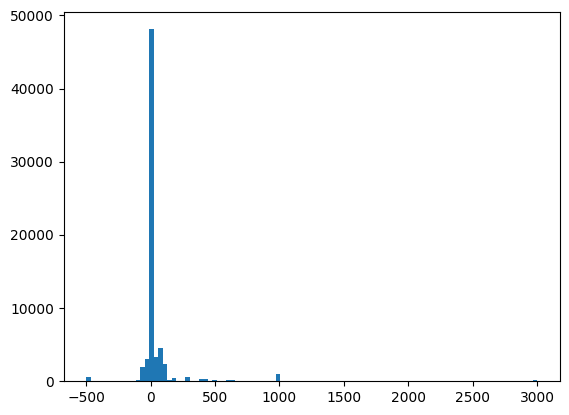

In [153]:
series = df[df["Tipo Oferta"] == "V"]['Precio Compra/Venta']
# plt.plot(np.arange(len(series)), series, label='Value');

plt.hist(series, bins=100)

In [140]:
# Be careful to execute that after the processing
series = df['Precio Compra/Venta']

# Normalization
series_scaled = tf.keras.utils.normalize(series.values.reshape(-1, 1)).flatten()

# Create sequences for training
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequence_length = 30
sequences = create_sequences(series_scaled, sequence_length)

In [112]:
# Build the model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(sequence_length, 1)),
    RepeatVector(sequence_length),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                                        
                                                                 
Total params: 198273 (774.50 KB)
Trainable params: 198273 (774.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [114]:
model.fit(sequences, sequences, epochs=1, batch_size=32, validation_split=0.2)

2343/2343 [==============================] - 54s 23ms/step - loss: 2.1006e-05 - val_loss: 7.3312e-07


In [125]:
# Calculate reconstruction errors
reconstructed_sequences = model.predict(sequences)
reconstructed_sequences = reconstructed_sequences.squeeze(axis=-1)  # Remove the singleton dimension
mse = np.mean(np.power(sequences - reconstructed_sequences, 2), axis=1)  # Calculate mean along axis 1

# Ensure the lengths of mse and series are aligned
series = df['Energía Compra/Venta'].values[:len(mse)]

# Define a custom condition for anomaly detection
threshold = np.percentile(mse, 95)
anomalies = (mse > threshold) | ((series == 0) & (series != 0))

# Mark anomalies in the data
anomaly_indices = np.where(anomalies)[0]
df['anomaly'] = 0
df.loc[df.index[anomaly_indices], 'anomaly'] = 1

2929/2929 [==============================] - 23s 8ms/step


KeyError: 'anomaly'

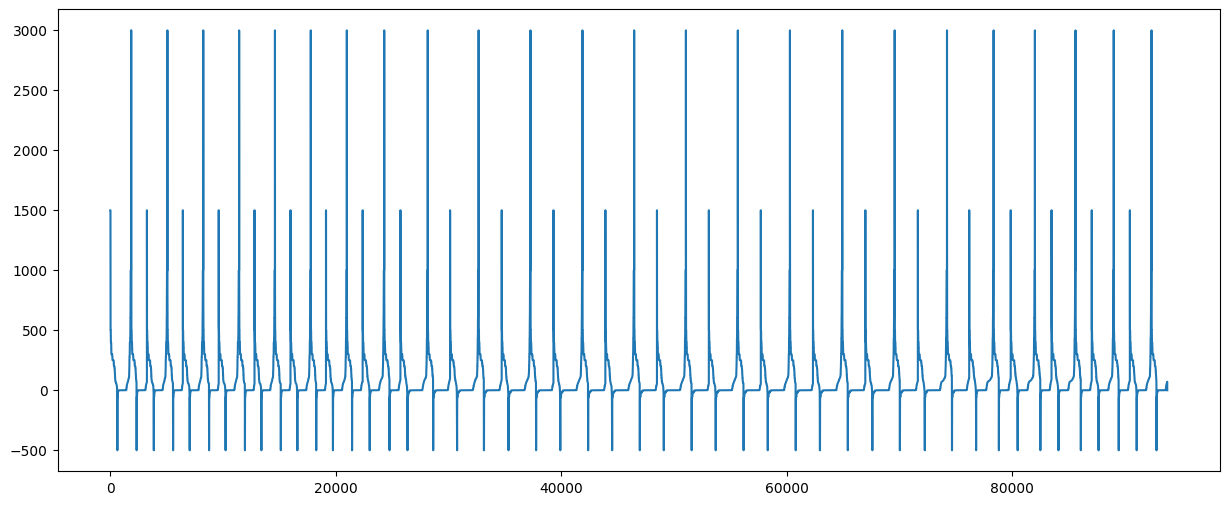

In [141]:
# Ensure the lengths of df.index and series are aligned
if len(df.index) != len(series):
    df = df[:len(series)]

plt.figure(figsize=(15, 6))
plt.plot(df.index, series, label='Value')

# Check if there are anomalies before plotting them
if df['anomaly'].any():
    plt.plot(df.index[df['anomaly'] == 1], series[df['anomaly'] == 1], 'ro', label='Anomalies')

plt.legend()
plt.show()